In [1]:
# Import libraries
import numpy as np
from numpy import linalg as LA

import random
import time
from IPython import display
import matplotlib.animation as animation
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True

import seaborn as sns

## MA934

## Solving linear systems - the direct way

### Backward substitution and LU factorisation

We start with the most basic solver - a backward substitution algorithm for a favourable dataset.

#### Expected input:
U - an nxn upper triangular matrix with non-zero entries on the diagonal <br>
b - an n-sized right hand side

#### Expected output:
x - an n-sized vector, solution to Ux=b 

#### A simple example

Designed for $x_1=5$, $x_2=1$ and $x_3=2$ as target solutions.

In [2]:
# Initialize upper triangular matrix
U0 = np.matrix([[1,2,3],[0,1,1],[0,0,5]])
# Initialize right hand side
b0 = np.matrix([[13],[3],[10]])
# Set the solution vector to zero
x0 = np.zeros_like(b0)

# Naive/direct translation of algorithm
n = b0.size
# First step considered outside loop to avoid 
# iterating index exceeding size of matrix
x0[n-1] = b0[n-1]/U0[n-1, n-1]

# Main loop
for i in range(n-2, -1, -1):
    h = 0 # helper variable
    for j in range (i+1, n):
        h += U0[i, j]*x0[j]
    x0[i] = (b0[i] - h)/U0[i, i]

# Consult result
print(np.matrix(x0))

[[5]
 [1]
 [2]]


#### Primary backward substitution function

More elegantly, we define a function we can use as part of more complicated workflows.

In [3]:
def simpleBackwardSubstitution(U: np.ndarray, b: np.ndarray) -> np.ndarray:
    n = b.size
    x = np.zeros_like(b)
    
    # First step
    x[n-1] = b[n-1]/U[n-1, n-1]
    
    # Main loop
    for i in range(n-2, -1, -1):
        h = 0 # helper variable
        for j in range (i+1, n):
            h += U[i, j]*x[j]
        x[i] = (b[i] - h)/U[i, i]

    return x

#### General solution

First test the function to make sure we retrieve the expected output, then design a larger ($64 \times 64$) matrix for a more realistic test.

In [4]:
# Use a function (defined below) instead and compare results
x0F = simpleBackwardSubstitution(U0,b0);
print("First verify the simple 3x3 case:")
print(np.matrix(x0F))

# Now for a real challenge - a larger upper triangular matrix
# Generate a random 64x64 matrix (the 0.1 offset is to ensure non-zero
# diagonal entries)
A = 0.1 + np.random.rand(64,64)
# Select upper triangular part
U = np.triu(A)
# ... and an appropriately sized vector, either artificially
b = U.sum(axis=1) # expect a solution of 1's if constructing the rhs this way
# b = np.random.rand(len(A),1) # uncomment if you wish to test more generally

x = simpleBackwardSubstitution(A,b)

# Compare result to in-built function
xInbuilt = np.linalg.solve(U, b)
# using Euclidean vector norm
errorNorm = LA.norm(x - xInbuilt)
print("The error norm between our solution and the default solver is ", errorNorm)

First verify the simple 3x3 case:
[[5]
 [1]
 [2]]
The error norm between our solution and the default solver is  3.7054528131284762e-09


### How do we factorise a matrix to retrieve triangular components?


#### Expected input:
A - an nxn matrix with invertible principal sub-matrices <br>

#### Expected output
L - an nxn unit lower triangular matrix <br>
U - an nxn regular upper triangular matrix


Define again a simple test matrix for which we know the desired answer (```testA```) and a larger random counterpart that acts as the primary target once we have convinced ourselves that the implemented algorithm works. (Aside: one simple test is not sufficient of course, and you are of course encouraged to try different examples and special cases before declaring victory.)


In [5]:
# A simple matrix to test out the functionality
testA = np.array([[1, 2, 4], [3, 8, 14], [2, 6, 13]])

# Generate a random matrix of specified size
randomA = np.random.rand(32,32)

#### LU factorisation function

Below is the straightfoward translation of the pseudocode for the standard LU factorisation (without pivoting).

In [6]:
def simpleLU(A,nk):
    
    n = len(A)
    
    # Initialise L and U matrices
    U = A.copy()
    L = np.identity(n)
    
    # Main loop as in the lecture notes pseudocode
    for k in range(nk):   # for full LU factorisation, nk = n (nk added as a variable only for the animation)
        for j in range (k+1,n):
            L[j,k] = U[j,k]/U[k,k]
            U[j,k] = 0
            for i in range(k+1,n):
                U[j,i] = U[j,i] - L[j,k]*U[k,i]  
    return L, U

We now deploy the implemented function for both the simple and the more complex case, while monitoring results and error norms.

In [7]:
# Execute the simple algorithm (defined via previous function)
testL, testU = simpleLU(testA, nk = len(testA))

# The simple results can be inspected visually
print(np.matrix(testL))
print(np.matrix(testU))

# The larger matrix case is simply stored for future verification
randomL, randomU = simpleLU(randomA, nk = len(randomA))

# Verify that the factorisation is indeed accurate
# using a classical 2-norm for the error matrix

# Simple case first
testErrorNorm = LA.norm(testA-testL@testU)
print ("The error norm of the solution for the simple case is: ", testErrorNorm)

# More complicated case next
randomErrorNorm = LA.norm(randomA-randomL@randomU)
print("The error norm of the solution for the larger case is: ", randomErrorNorm)

# If we wish to restrict our verification for a specific accuracy level: 
# print ("The error norm of the solution when testing against standard multiplication for the larger case is: ",end="")
# print ("{0:.6f}".format(randomErrorNorm))

# Can also verify the in-built Python functionality for LU via scipy
# tP, tL, tU = lu(testA)
# rP, rL, rU = lu(randomA)

[[1. 0. 0.]
 [3. 1. 0.]
 [2. 1. 1.]]
[[1 2 4]
 [0 2 2]
 [0 0 3]]
The error norm of the solution for the simple case is:  0.0
The error norm of the solution for the larger case is:  2.697379928804404e-13


In [8]:
# Required for creating the animation in the LU factorisation below

# pip install nodejs

## LU factorisation in action (soon in cinemas near you)

<IPython.core.display.Javascript object>


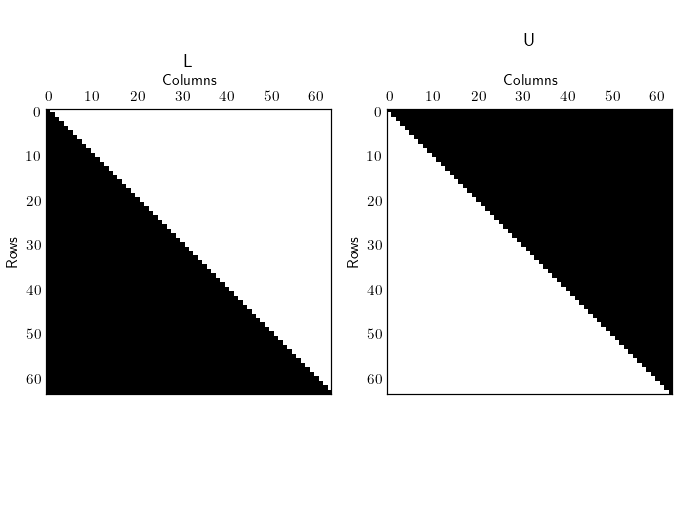

In [9]:
# This solution version (with %matplotlib notebook) works via the Jupyter Notebook
# (rather than JupyterLab) environment. If you are used to working in the latter, 
# a few additional installs are required, see e.g.
# https://stackoverflow.com/questions/51922480/javascript-error-ipython-is-not-defined-in-jupyterlab
# for details/solutions.

# Initialize the layout that will be used for animation
%matplotlib notebook

# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1,2)
fig.tight_layout()

# matrix size nxn
n=64

# Define A
rndA = np.random.rand(n,n) 

# Initialisation and making the plots nicer
line1 = ax1.spy(np.eye(n))
ax1.set_xlabel('Columns')
ax1.set_ylabel('Rows')
ax1.set_title('L \n',y=10.08)
ax1.tick_params(axis='both', which='both', length=0)
ax1.xaxis.set_label_position('top') 

line2 = ax2.spy(rndA)
ax2.set_xlabel('Columns')
ax2.set_ylabel('Rows')
ax2.set_title('U\n')
ax2.tick_params(axis='both', which='both', length=0)
ax2.xaxis.set_label_position('top') 


# Helper function that updates the L and U matrices and returns a new image of
# the updated L and U. animate is the function that FuncAnimation calls
def animate(frame):
    L,U = simpleLU(rndA,nk=frame) 
    line1 = ax1.spy(L)
    line2 = ax2.spy(U)  
    return line1, line2

# This creates the animation
anim = animation.FuncAnimation(fig, animate, frames=n, 
                                interval=250, repeat = False, blit=True)
plt.show()

**Exercise 1:** using the above functionality, implement and test your very own linear system solver. 

**Exercise 2:** consult subsection $5.2.2$ in the notes and implement Crout's algorithm for LU decomposition using partial pivoting. Construct a suitable example that showcases its capabilities (e.g. in which non-pivoting methods fail).